# Introduction à la Science des données



## Travail pratique 04 – Modèles et évaluation

### Table des matières

[Exercice 1: Modèle à base de règles](#Exercice-1:-Modèle-à-base-de-règles)
- [1.1 Boxplots, pairplot et choix des variables](#1.1-Boxplots,-pairplot-et-choix-des-variables)
- [1.2 Création du modèle à base de règles](#1.2-Création-du-modèle-à-base-de-règles)
    -  [1.2.1 Définition des règles](#1.2.1-Définition-des-règles)
    -  [1.2.2 Prédictions](#1.2.2-Prédictions)
    -  [1.2.3 Scores et matrices de confusion](#1.2.3-Scores-et-matrices-de-confusion)
- [1.3 Question](#1.3-Question)

[Exercice 2: L'algorithme des k plus proches voisins (k-NN)](#Exercice-2:-L'algorithme-des-k-plus-proches-voisins-(k-NN))
- [2.1 Préparation des données](#2.1-Préparation-des-données)
- [2.2 Validation hold-out](#2.2-Validation-hold-out)
- [2.3 N_fold cross validation](#2.3-N_fold-cross-validation)

[Exercice 3: Evaluation des résultats et matrice de confusion](#Exercice-3:-Evaluation-des-résultats-et-matrice-de-confusion)

[Exercice 4: L’algorithme LVQ](#Exercice-4:-L’algorithme-LVQ)

---

**Informations de groupe:**

- Groupe: **A COMPLETER**


- Prénoms1 Noms1 **A COMPLETER**
- Prénoms2 Noms2 **A COMPLETER**
- (Prénoms3 Noms3 **A COMPLETER**)


---

**Professeurs**: Carlos Peña et Stephan Robert

**Assistant(s)**: Thibault Schowing, Arthur Babey

**Contact**: prenom.nom@heig-vd.ch ou de préférence via Teams 

**Rendu**:

- Date: 10.12.2023, 23h55

- Travail par groupe de 2 ou 3. Il est impératif de vous enregistrer dans un groupe sur Cyberlearn. Une fois ceci fait, une seule personne du group a besoin de rendre le TP et le feedback est automatiquement envoyé à chaque membre du groupe. 


- Une fois complété, rendez directement le notebook nommé correctement comme suit "**TP4_ISD_SA2023_Nom1_Nom2(_Nom3).ipynb**" en remplaçant par vos noms (pour ceux avec plusieurs noms de famille, vous pouvez mettre juste le premier et mettre les Prénoms et noms en entier ci-dessus.) Uploadez en suite votre fichier sur Cyberlearn dans la section prévue à cet effet. 


- Les questions sont généralement indiquées en **gras** ou par une liste d'instructrions et les endroits où répondre sont indiqués par un "*Réponse:*" pour les réponses textuelles. 


- Pour les réponses nécessitant d'écrire du code, les cellules ont déjà été crées et un commentaire indique où/quoi répondre.


- Note: Ce TP est noté sur 6 


<div class="alert alert-block alert-success">
<b>Objectifs </b>
</div>

- Créer un modèle simple à base de règles
- Utiliser l'algorithme kNN vu en classe pour traiter le problème de classification des vins
- Evaluer les modèles à l'aide d'une matrice de confusion
- L'algorithme LVQ (Learning Vector Quantization)

<div class="alert alert-block alert-info">
<b>Corrections: </b> Ce notebook vous sera renvoyé via Cyberlearn ou  un autre canal. Les informations principales concernant les corrections seront indiquées après chaque section (banière bleue) avec le nombre de points. Il est possible que des remarques concernant le code soient directement ajoutées dans celui-ci.
</div>


**Veillez tout d'abord à installer les packages suivants dans l'environnement correspondant au kernel que vous utilisez s'ils ne le sont pas déjà.**

<div class="alert alert-block alert-danger">
<b>Merci de ne pas mettre de commande pip dans le code du notebook ou de le commenter une fois celui-ci exécuté. </b> De plus, si vous ajoutez des "cellules brouillon" pour tester des valeurs de variables, sentez vous libre de les supprimer une fois vos tests effectués pour rendre un rapport propre et lisible. 
</div>

 
    
    

In [1]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from math import sqrt
import itertools

# Package scikit-learn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Pour k-NN
from collections import Counter, defaultdict

# Pour validation hold-out

import random
from random import randrange
random.seed(10)



## Exercice 1: Modèle à base de règles

(20 points)


Exécuter le code ci-dessous afin de lire le fichier wine.data et créez les graphiques.

In [2]:
headers = ['Note', 'Alcool', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 
           'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 
           'Hue', 'OD280/OD315 of diluted wines', 'Proline']

wines = pd.read_csv('./wine.data', names=headers)



### 1.1 Boxplots, pairplot et choix des variables



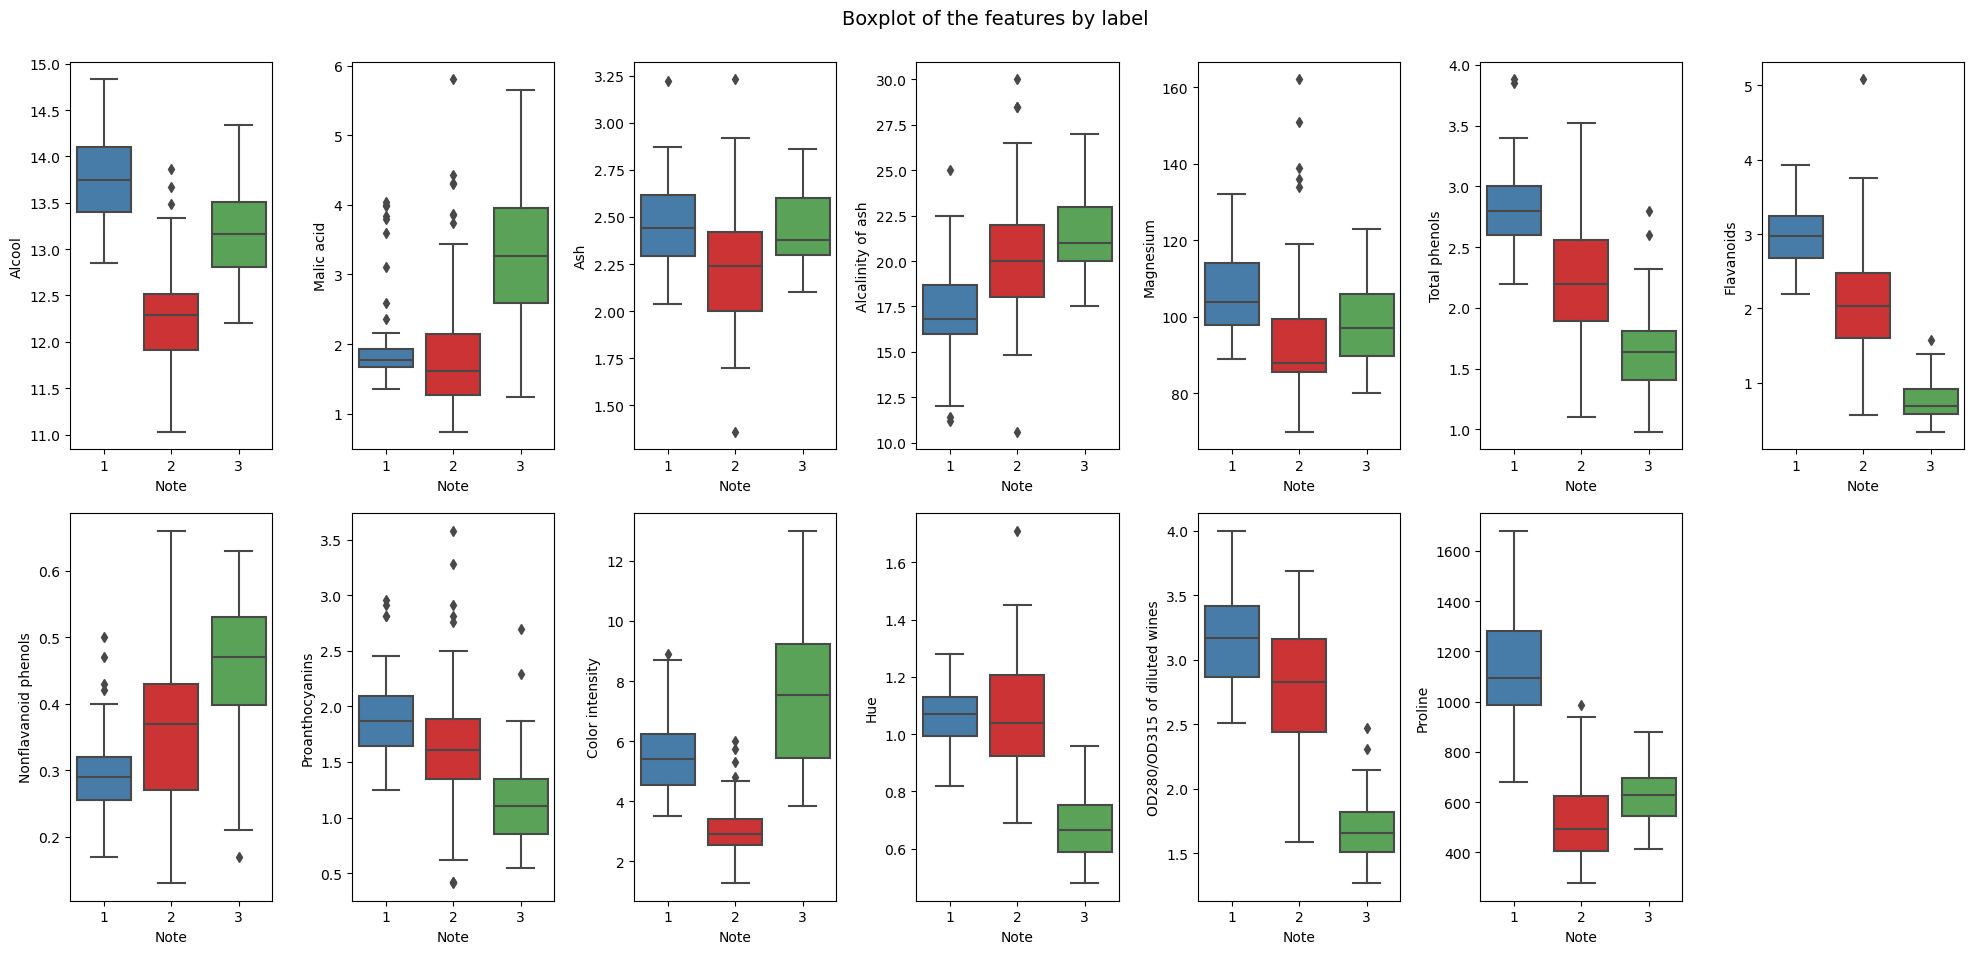

In [3]:
fig, axs = plt.subplots(2, 7, figsize=(20, 10))
axs = axs.flatten()
for i, col in enumerate(wines.columns[1:]):
    sns.boxplot(x="Note",y=col, data=wines, ax=axs[i], palette={1: '#377eb8', 2: '#e41a1c', 3: '#4daf4a'})
fig.suptitle('Boxplot of the features by label', fontsize=14)    
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
fig.delaxes(axs[13])

In [4]:
#g = sns.pairplot(wines, hue='Note', palette={1: '#377eb8', 2: '#e41a1c', 3: '#4daf4a'})
#plt.suptitle('Scatter plots by pair, colorized by label', fontsize=18, y=1.02);

Pour plusieurs variables on voit qu'il est possible de séparer les trois classes assez aisément. Ainsi les variables `Alcool`, `Color intensity` et `Flavanoids` semblent les plus adaptées à cette tâche. 



### 1.2 Création du modèle à base de règles

Suivez la structure du code ci-après pour implémenter un modèle à base de règles. Complétez les parties manquantes et écrivez les fonctions demandées. **Lisez bien les commentaires afin de bien comprendre la logique implémentée**. 


#### 1.2.1 Définition des règles

(6 points)

Dans cette partie vous allez écrire les règles permettant de distinguer les trois classes (Note) à l'aide des variables `Alcool`, `Color intensity` et `Flavanoids`. Utilisez pour cela les valeurs que vous avez trouvées au TP3 ou servez vous des graphiques ci-dessus pour les déterminer. 

Servez-vous de la fonction donnée en exemple pour créer les fonctions suivantes (**respectez les noms !**): 

- *class_by_alcool()*: utilise la variable Alcool uniquement. 
- *class_by_flavanoids()*: utilise la variable Flavanoids uniquement.
- *class_by_color_intensity()*: utilise la variable Color intensity uniquement
- *class_by_flav_alcool()*: utilise les variables Flavanoids et Alcool
- *class_by_color_alcool()*: utilise les variables Color intensity et Alcool
- *class_by_color_flav()*: utilise les variables Color intensity et Flavanoids



In [5]:
def class_by_alcool(df):
    """
    Retourne la classe (1, 2 ou 3) selon la variable Alcool.
    """
    if df["Alcool"] >= 13.0:
        return 1
    elif df["Alcool"] >= 12.0:
        return 2
    else:
        return 3

def class_by_flavanoids(df):
    """
    Retourne la classe (1, 2 ou 3) selon la variable Flavanoids.
    """
    if df["Flavanoids"] >= 2.0:
        return 1
    elif df["Flavanoids"] >= 1.2:
        return 2
    else:
        return 3

def class_by_color_intensity(df):
    """
    Retourne la classe (1, 2 ou 3) selon la variable Color intensity.
    """
    if df["Color intensity"] >= 6.0:
        return 1
    elif df["Color intensity"] >= 3.0:
        return 2
    else:
        return 3

def class_by_flav_alcool(df):
    """
    Retourne la classe (1, 2 ou 3) selon les variables Flavanoids et Alcool.
    """
    if df["Flavanoids"] >= 2.0 and df["Alcool"] >= 13.0:
        return 1
    elif df["Flavanoids"] >= 1.2 and df["Alcool"] >= 12.0:
        return 2
    else:
        return 3

def class_by_color_alcool(df):
    """
    Retourne la classe (1, 2 ou 3) selon les variables Color intensity et Alcool.
    """
    if df["Color intensity"] >= 6.0 and df["Alcool"] >= 13.0:
        return 1
    elif df["Color intensity"] >= 3.0 and df["Alcool"] >= 12.0:
        return 2
    else:
        return 3

def class_by_color_flav(df):
    """
    Retourne la classe (1, 2 ou 3) selon les variables Color intensity et Flavanoids.
    """
    if df["Color intensity"] >= 6.0 and df["Flavanoids"] >= 2.0:
        return 1
    elif df["Color intensity"] >= 3.0 and df["Flavanoids"] >= 1.2:
        return 2
    else:
        return 3


# Aperçu des premières lignes avec les nouvelles colonnes de prédiction
wines.head()


,Note,Alcool,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


#### 1.2.2 Prédictions

(6 points)

Pour chacune des règles créées ci-dessus, ajoutez une colonne dans df, une copie du DataFrame wines. Utilisez des noms parlants comme "pred_alcool" ou "pred_alcool_flav" afin que l'on comprenne bien de quelle prédiction il s'agit. Un exemple de l'utilisation de la fonction apply() est donné en commentaire. 




In [6]:
# Création d'une copie du DataFrame wines
df = wines.copy()

# Application des fonctions de classification pour créer les colonnes de prédiction dans df
df["pred_alcool"] = df.apply(class_by_alcool, axis=1)
df["pred_flavanoids"] = df.apply(class_by_flavanoids, axis=1)
df["pred_color_intensity"] = df.apply(class_by_color_intensity, axis=1)
df["pred_flav_alcool"] = df.apply(class_by_flav_alcool, axis=1)
df["pred_color_alcool"] = df.apply(class_by_color_alcool, axis=1)
df["pred_color_flav"] = df.apply(class_by_color_flav, axis=1)

# Aperçu des premières lignes avec les nouvelles colonnes de prédiction
df.head()


,Note,Alcool,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,pred_alcool,pred_flavanoids,pred_color_intensity,pred_flav_alcool,pred_color_alcool,pred_color_flav
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1,1,2,1,2,2
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1,1,2,1,2,2
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1,1,2,1,2,2
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1,1,1,1,1,1
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1,1,2,1,2,2


#### 1.2.3 Scores et matrices de confusion

(6 points)

Affichez les scores (Accuracy) et matrices de confusion *pour chaque règles*. Pour cela, on utilise les fonctions [accuracy_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), [confusion_matrix()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) et [ConfusionMatrixDisplay()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) fournies par ScikitLearn et importée en amont de ce Notebook. Utilisez le code donné en exemple ci-dessous. 



Accuracy for pred_alcool: 0.57


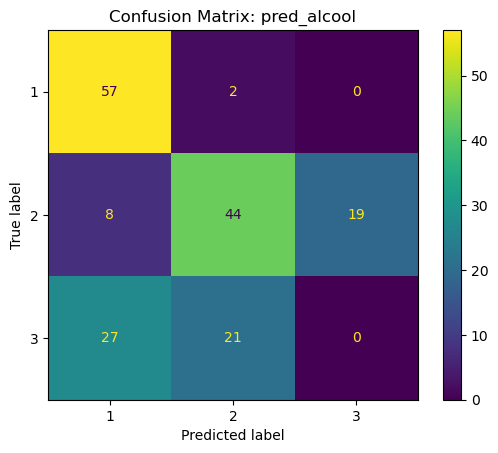

Accuracy for pred_flavanoids: 0.71


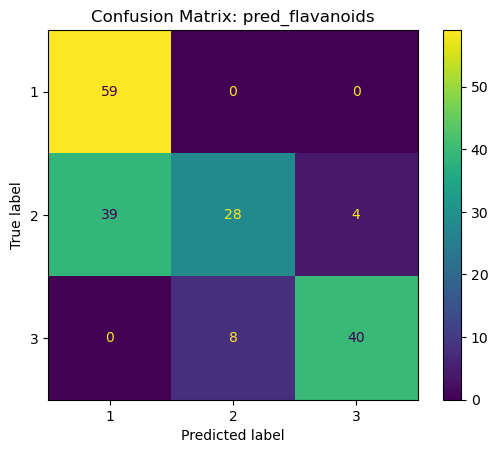

Accuracy for pred_color_intensity: 0.29


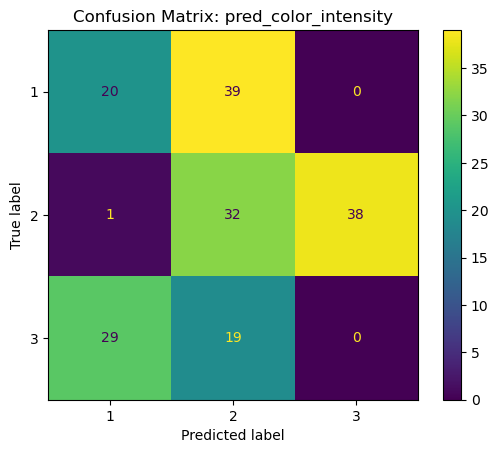

Accuracy for pred_flav_alcool: 0.80


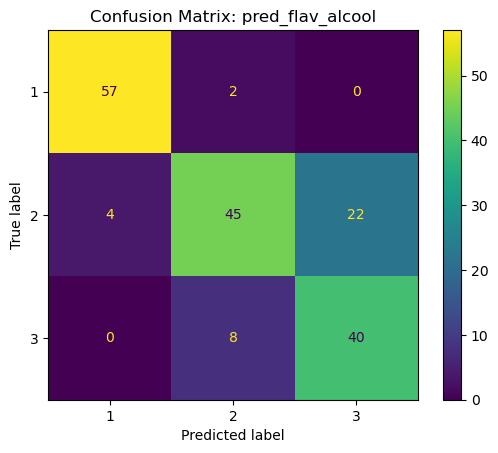

Accuracy for pred_color_alcool: 0.25


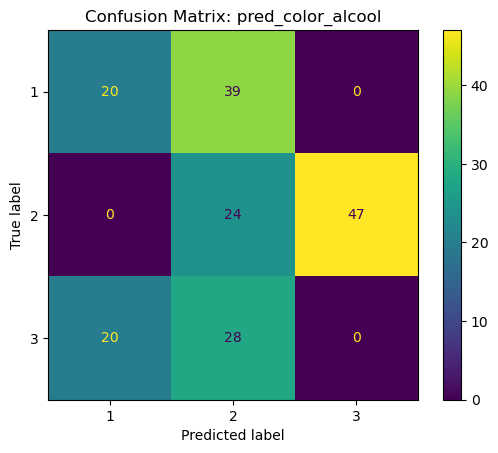

Accuracy for pred_color_flav: 0.51


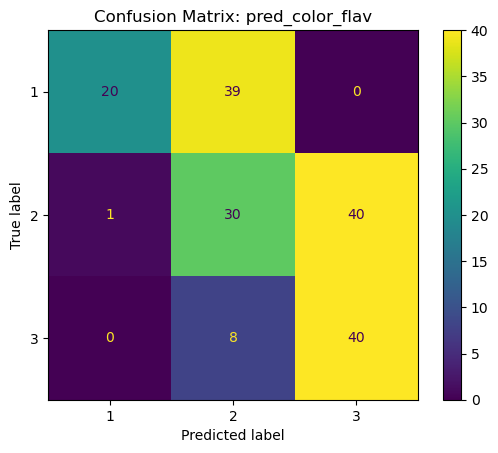

In [7]:
# ------------------------------------------------------------------
# Pour chaque modèle, affichez le score (Accuracy) et la matrice de confusion (code ci-dessous)
# ------------------------------------------------------------------

# Vous pouvez écrire une boucle ou afficher le score et la matrice à la suite ou dans des cellules séparées. 
# Libre à vous de choisir la solution qui vous plait le plus !

# Liste des colonnes de prédiction
prediction_columns = ["pred_alcool", "pred_flavanoids", "pred_color_intensity", 
                      "pred_flav_alcool", "pred_color_alcool", "pred_color_flav"]

# Calcul et affichage des scores (Accuracy) et matrices de confusion pour chaque règle
for col in prediction_columns:
    score = accuracy_score(df["Note"], df[col])
    print(f"Accuracy for {col}: {score:.2f}")

    cm = confusion_matrix(df["Note"], df[col])
    disp = ConfusionMatrixDisplay(cm, display_labels=["1", "2", "3"])
    disp.plot()
    plt.title(f"Confusion Matrix: {col}")
    plt.show()



____

### 1.3 Question

(2 points)

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>Q </b></font>Laquelle de vos règles donne le meilleur résultat ? Y a-t-il une classe (Note) plus difficile à prédir qu'une autre ?</p>

*Réponse:* 
La règle qui donne le meilleur résultat, selon les scores de précision (Accuracy) calculés, est pred_flav_alcool, avec un score de 0.80 (80%). La class plus difficil à prédire serait la note 2.



<div class="alert alert-block alert-info">
<b>Corrections 1.1 - 1.3: </b> Points obtenus: /20
</div>

Remarques: 

___
## Exercice 2: L'algorithme des k plus proches voisins (k-NN)



Complétez les docstrings du code de k-NN vu en classe donné ci-dessous pour traiter le problème de classification des vins et testez la performance (accuracy) des modèles pour K=1,2,3,5,7 et 10. Les endroits où vous devez modifier ou ajouter du code sont indiqués. Lisez bien la donnée pour savoir quoi modifier et où. 

- Utilisez la méthode de validation hold-out (calculez la moyenne des performances en répétant le split 10 fois). 
- Utilisez la validation croisée avec *n_folds = 5*
- Testez chaque méthode avec le dataset brut et le dataset normalisé/standardisé


Pour chaque k, vous aurez donc 10 valeurs pour la validation hold-out et 5 pour n_fold.  



- 2.1 Complétez les docstrings (description de la fonction et des paramètres, pour les paramètres pas besoin d'indiquer le type exacte)
- 2.2 Préparration des données (normalisation)
- 2.3 Validation hold-out
- 2.4 N_fold cross validation¶

---

### Exercice 2.1: Complétez les docstrings. 
(6 points)



In [8]:
# Code du cours - TODO Complétez les docstrings 


def train_test_split(dataset, split=0.60):
    """
    
    """
    train = list()
    train_size = split * len(dataset)
    test = list(dataset)
    while len(train) < train_size:
        index = randrange(len(test))
        train.append(test.pop(index))
    return train, test


def euclidean_distance(row1, row2):
    """
    
    """

    distance = 0.0
    for i in range(1, len(row1)): # All columns except the first one (Note) - Wrong in course's PDF
        distance += (row1[i] - row2[i])**2
    
    return sqrt(distance)


def get_neighbors(train, test_row, num_neighbors):
    """
    
    """
    distances = list()
    for train_row in train:
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors


def predict_classification(train: pd.DataFrame, test_row, num_neighbors):
    """
    
    """
    neighbors = get_neighbors(train, test_row, num_neighbors)
    output_values = [row[0] for row in neighbors]
    #print(f"Output values classification: {output_values}")
    prediction = max(set(output_values), key=output_values.count)
    return prediction


def accuracy_metric(actual: list[float], predicted: list[float]):
    """
    
    """
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


def cross_validation_split(dataset, n_folds):
    """
    
    """
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for _ in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split





<div class="alert alert-block alert-info">
<b>Corrections 2.1: </b> Points obtenus: /6
</div>

Remarques: 

### 2.2 Préparation des données

(6 points, 2 par question)

Création de deux datasets: 
- un avec les données brutes
- un avec les données normalisées

**Lisez sans modifier le code ci-dessous pour en comprendre le sens et répondez aux questions.**

In [9]:
# Préparation des datasets - rien à modifier

#=====================================================================
# Préparation des données brutes 
#=====================================================================

# Conversion en liste de listes au lieu de DataFrame
data = wines.values.tolist()

#=====================================================================
# Préparation des données normalisées
#=====================================================================


# Différents moyens de standardiser les données mise à disposition par Scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Nous allons utiliser le StandardScaler, qui va normaliser les données avec une moyenne de 0 et un écart-type de 1
scaler = StandardScaler()
scaler_string = "StandardScaler" # pour l'affichage dans le titre des plots si nécessaire


# Créer une copie et prendre une liste des colonnes des données indépendantes (entrées)
df_normalized = wines.copy()
cols = wines.columns[wines.columns != 'Note']

# Remplacer les colonnes des données par les données transformées
df_normalized[cols] = scaler.fit_transform(df_normalized[cols])

# conversion en liste de listes pour k-NN
data_normalized = df_normalized.values.tolist()

# K's à tester
Ks = [1, 2, 3, 5, 7, 10]



<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>Q </b></font> Qu'est-ce que la standardisation des données ? </p>

Décrivez le concept en quelques mots. Attention, les termes "Normalisation" et "Standardisation" sout souvents mélangés mais le concept général reste le même !


*Réponse:*


____

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>Q </b></font> Quelles sont les différences entre les StandardScaler, MinMaxScaler et RobustScaler ?</p>

Note: Aidez-vous de [la doc](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) ou d'autres ressources pour répondre. 


*Réponse:*


____

### Comparaison des boxplots avec des données normalisées

Comparez les boxplots ci-dessous. 

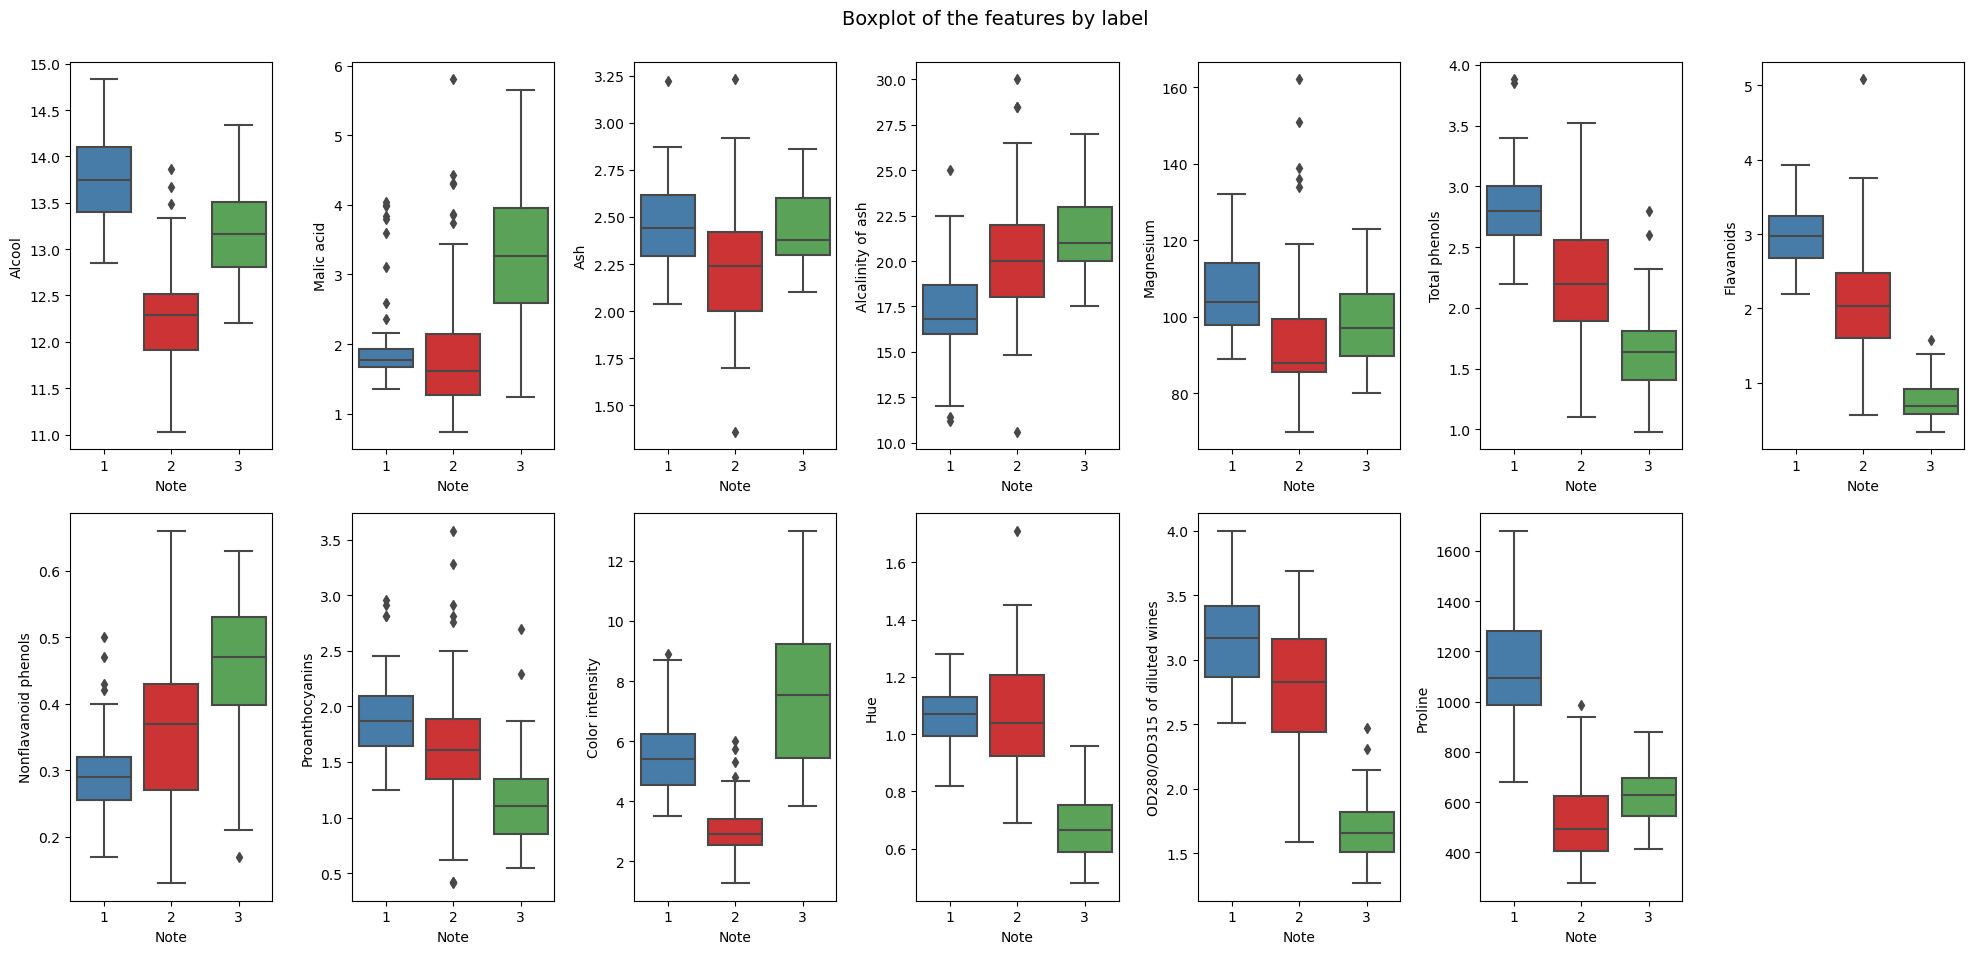

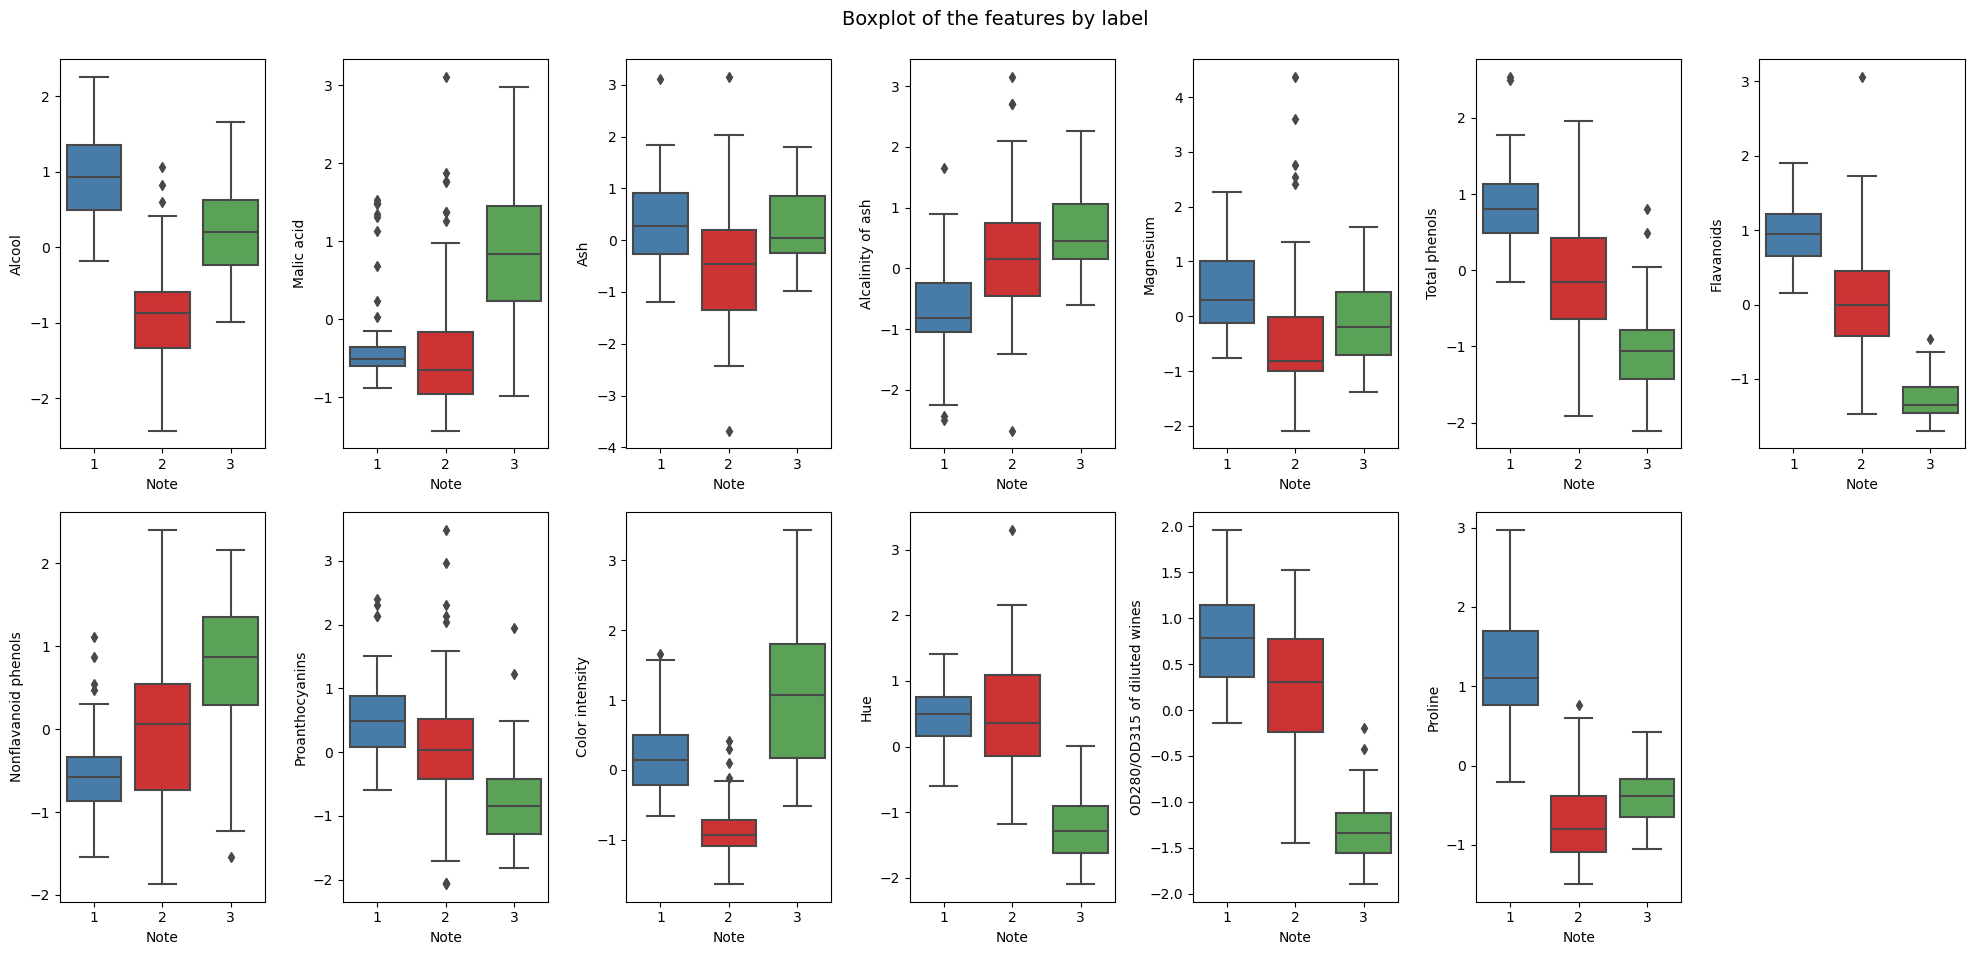

In [10]:
for df in [wines, df_normalized]:
    fig, axs = plt.subplots(2, 7, figsize=(20, 10))
    axs = axs.flatten()
    for i, col in enumerate(df.columns[1:]):
        sns.boxplot(x="Note",y=col, data=df, ax=axs[i], palette={1: '#377eb8', 2: '#e41a1c', 3: '#4daf4a'})
    fig.suptitle('Boxplot of the features by label', fontsize=14)    
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    fig.delaxes(axs[13])
    plt.show()

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>Q </b></font> Quelles différences observez-vous entre les boxplots des données normalisées ou non ?</p>

*Réponse:*

---

<div class="alert alert-block alert-info">
<b>Corrections 2.2: </b> Points obtenus: /6
</div>

Remarques: 

### 2.3 Validation hold-out


#### 2.3.1 Implémentation
(6 points)


Complétez le code ci-dessous en suivant les indications en commentaire. Respectez le nombre de lignes indiqué.

Utilisez en premier le dataset "***data***" puis une fois votre code fonctionnel, copiez la cellule (ou ajoutez un niveau de boucle si vous préférez) et remplacez le par le dataset avec les données normalisées: "***data_normalized***". N'oubliez pas de modifier le titre des graphiques pour plus de clareté (indiquez quel données sont utilisées). 

*Supprimez aussi le print() dans la boucle qui est là pour que le code fonctionne avant que vous l'ayez complété.* 


----- N = 0 - k = 1 -----
----- N = 0 - k = 2 -----
----- N = 0 - k = 3 -----
----- N = 0 - k = 5 -----
----- N = 0 - k = 7 -----
----- N = 0 - k = 10 -----
----- N = 1 - k = 1 -----
----- N = 1 - k = 2 -----
----- N = 1 - k = 3 -----
----- N = 1 - k = 5 -----
----- N = 1 - k = 7 -----
----- N = 1 - k = 10 -----
----- N = 2 - k = 1 -----
----- N = 2 - k = 2 -----
----- N = 2 - k = 3 -----
----- N = 2 - k = 5 -----
----- N = 2 - k = 7 -----
----- N = 2 - k = 10 -----
----- N = 3 - k = 1 -----
----- N = 3 - k = 2 -----
----- N = 3 - k = 3 -----
----- N = 3 - k = 5 -----
----- N = 3 - k = 7 -----
----- N = 3 - k = 10 -----
----- N = 4 - k = 1 -----
----- N = 4 - k = 2 -----
----- N = 4 - k = 3 -----
----- N = 4 - k = 5 -----
----- N = 4 - k = 7 -----
----- N = 4 - k = 10 -----
----- N = 5 - k = 1 -----
----- N = 5 - k = 2 -----
----- N = 5 - k = 3 -----
----- N = 5 - k = 5 -----
----- N = 5 - k = 7 -----
----- N = 5 - k = 10 -----
----- N = 6 - k = 1 -----
----- N = 6 - k = 2 -----
----- 

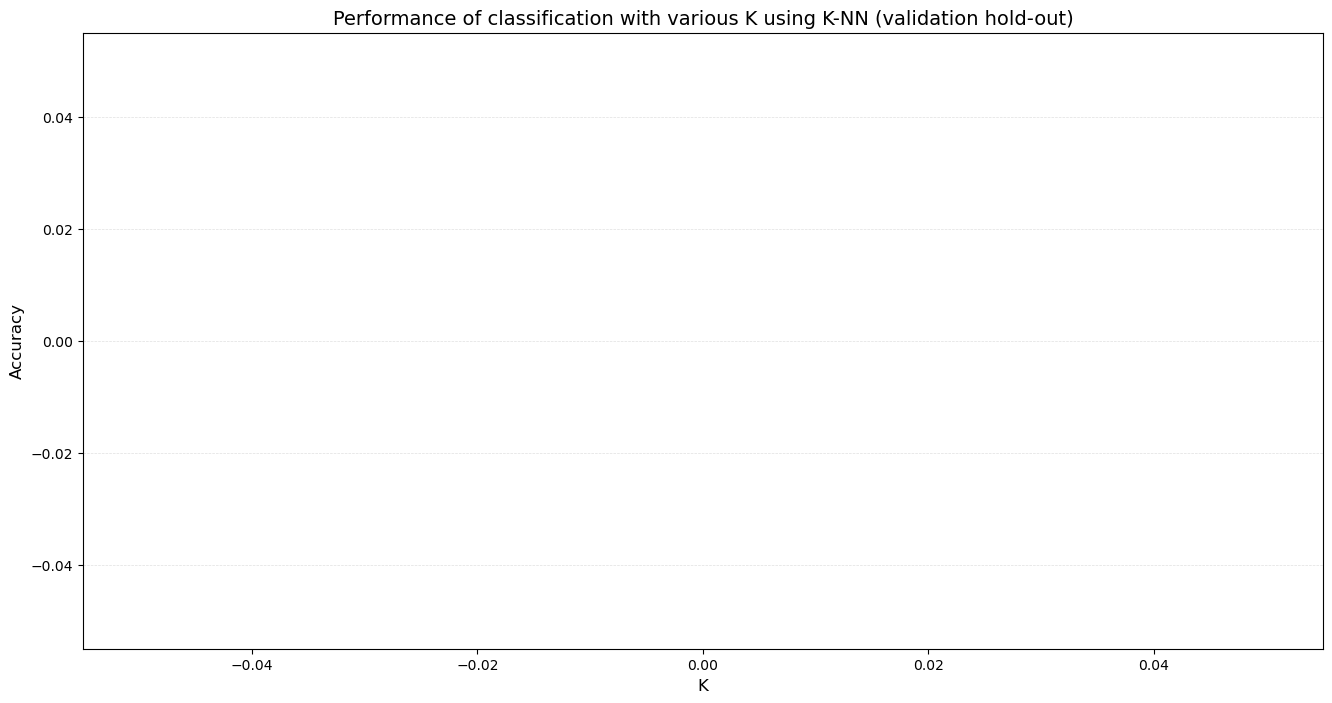

In [11]:
# Complétez le code ci-dessous. Attention, les données sont dans "data"/"data_normalized" et non dans "wines":


# Nous voulons 10 répétitions avec la méthode validation hold-out
N_REPETITIONS = 10

# Nous allons stocker les résultats dans un dictionnaire, avec pour chaque k une liste d'accuracy. 
results = defaultdict(list)

# Pour chaque validation hold-out (test et train set différents) on test chaque k
for i in range(N_REPETITIONS):
    for k in Ks:
        print(f"----- N = {i} - k = {k} -----")  # Vous pouvez supprimer cette ligne une fois votre code fonctionnel
                                                 # Pour que le code tourne, la boucle ne doit pas être vide ;-)  
        
        # Faire le train-test split avec split = 0.8. 
        # La fonction retourne deux éléments, utilisez le unpacking pour les extraire (train, test = fct())
        # - complétez - 1 ligne
        
        
        # Obtenir les prédictions à l'aide de la fonction predict_classification()
        # Aide: utilisez la compréhension de liste:  prédictions = [prediction(...) for ... in ...] 
        #                                                                           pour chaque observation de test
        #       Vous devez générer une liste de prédictions (1, 2 ou 3), que vous comparerez en dessous avec 
        #         les valeurs justes pour obtenir l'accuracy.
        
        # - complétez - 1 ligne
        
        
        # Joindre à results[k] la liste des accuracies (obtenu avec la fonction accuracy_metric() ci dessus)
        # Aide: utilisez la méthode append() pour joindre l'accuracy aux résultats
        # Aide: utilisez la méthode accuracy_metric() pour obtenir l'accuracy
        # Aide: Vous avez une liste de prédictions et un dataframe original (test)
        #       utilisez la compréhension de liste pour créer la liste des données originales:
        #         [colone "note" pour chaque ligne des tests]
        
        # - complétez - 1 ligne (si vous y arrivez, sinon plus)
        

# Ne pas modifier ci-dessous sauf le titre
_, ax = plt.subplots(1, 1, figsize=(16, 8))

means = [np.mean(v) for v in results.values()]
stds = [np.std(v) for v in results.values()]

ax.errorbar(results.keys(), means, stds, linestyle='None', marker='D', color='darkgreen')
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('K', fontsize=12)
ax.set_title('Performance of classification with various K using K-NN (validation hold-out)', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.4, lw=0.5)

#### 2.3.2 Questions

(2 points)

___

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>Q </b></font> Pour quelle valeur(s) de k le modèle est-il le plus efficace ?</p>

Note: les résultats peuvent varier d'une exécution à l'autre. Indiquez la tendance générale que vous observez.

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>Q </b></font> Une fois les données normalisées, quelle différence observe-t-on ?</p>

___

*Réponse (pour les deux questions):*

<div class="alert alert-block alert-info">
<b>Corrections 2.3: </b> Points obtenus: /8
</div>

Remarques: 

___

___

### 2.4 N_fold cross validation



Si vous voulez vous raffraichir sur le sujet, voici [une courte vidéo de StatQuest](https://www.youtube.com/watch?v=fSytzGwwBVw) (ou [une autre en français](https://www.youtube.com/watch?v=xWgGOHiROmc)). Ne vous attardez pas trop sur les détails et variations de la validation croisée sauf si cela vous intéresse !



#### 2.4.1 Implémentation

(6 points)

Complétez le code ci-dessous en suivant les indications en commentaire, cette fois en utilisant la N-fold cross validation (souvent appelée k-fold, mais là on veut pas confondre avec notre k de k-NN). 

Utilisez en premier le dataset "***data***" puis une fois votre code fonctionnel, copiez les cellules (ou ajoutez un niveau de boucle) et remplacez le par le dataset avec les données normalisées: "***data_normalized***". N'oubliez pas de modifier le titre des graphiques pour que le résultat soit lisible. 

*Supprimez aussi le print() dans la boucle qui est là pour que le code fonctionne avant que vous l'ayez complété.* 

In [12]:

results_nfold = defaultdict(list)

# Les données sont divisées en plusieurs folds 
folds = cross_validation_split(data, n_folds=5)
    
for k in Ks:
    
    # Listes qui vont contenir les valeurs prédites et les vraies valeurs
    predictions = []
    actuals = []

    for test_i in range(len(folds)):
        print(f"----- Fold = {test_i } - k = {k} -----") 
        
        # train = tout sauf le fold i, qui est utilisé pour tester.
        # Permet de créer une liste à partir des éléments de folds, y compris si c'est vide. 
        train = list(itertools.chain.from_iterable(folds[:test_i] + folds[test_i+1:]))
            
        # test = Fold courrant, utilisé pour tester
        # - complétez - 1 ligne
        
        
        # Effectue la prédiction et l'ajoute au tableau prédictions[] pour chaque element dans test
        # predictions += [...fonction pour faire la classification définie en début de point 2.... for....in ....]
        # - complétez - 1 ligne
        
        
        # Remplit la liste "actual" avec les valeurs réelles
        # - complétez - 1 ligne
            
    
    # Mettez le résultat de "accuracy_metric(...,...)" dans results_nfold[k]
    # - complétez - 1 ligne
    
    print(f'Performance with k={k}: {results_nfold[k]}')
    


----- Fold = 0 - k = 1 -----
----- Fold = 1 - k = 1 -----
----- Fold = 2 - k = 1 -----
----- Fold = 3 - k = 1 -----
----- Fold = 4 - k = 1 -----
Performance with k=1: []
----- Fold = 0 - k = 2 -----
----- Fold = 1 - k = 2 -----
----- Fold = 2 - k = 2 -----
----- Fold = 3 - k = 2 -----
----- Fold = 4 - k = 2 -----
Performance with k=2: []
----- Fold = 0 - k = 3 -----
----- Fold = 1 - k = 3 -----
----- Fold = 2 - k = 3 -----
----- Fold = 3 - k = 3 -----
----- Fold = 4 - k = 3 -----
Performance with k=3: []
----- Fold = 0 - k = 5 -----
----- Fold = 1 - k = 5 -----
----- Fold = 2 - k = 5 -----
----- Fold = 3 - k = 5 -----
----- Fold = 4 - k = 5 -----
Performance with k=5: []
----- Fold = 0 - k = 7 -----
----- Fold = 1 - k = 7 -----
----- Fold = 2 - k = 7 -----
----- Fold = 3 - k = 7 -----
----- Fold = 4 - k = 7 -----
Performance with k=7: []
----- Fold = 0 - k = 10 -----
----- Fold = 1 - k = 10 -----
----- Fold = 2 - k = 10 -----
----- Fold = 3 - k = 10 -----
----- Fold = 4 - k = 10 -----


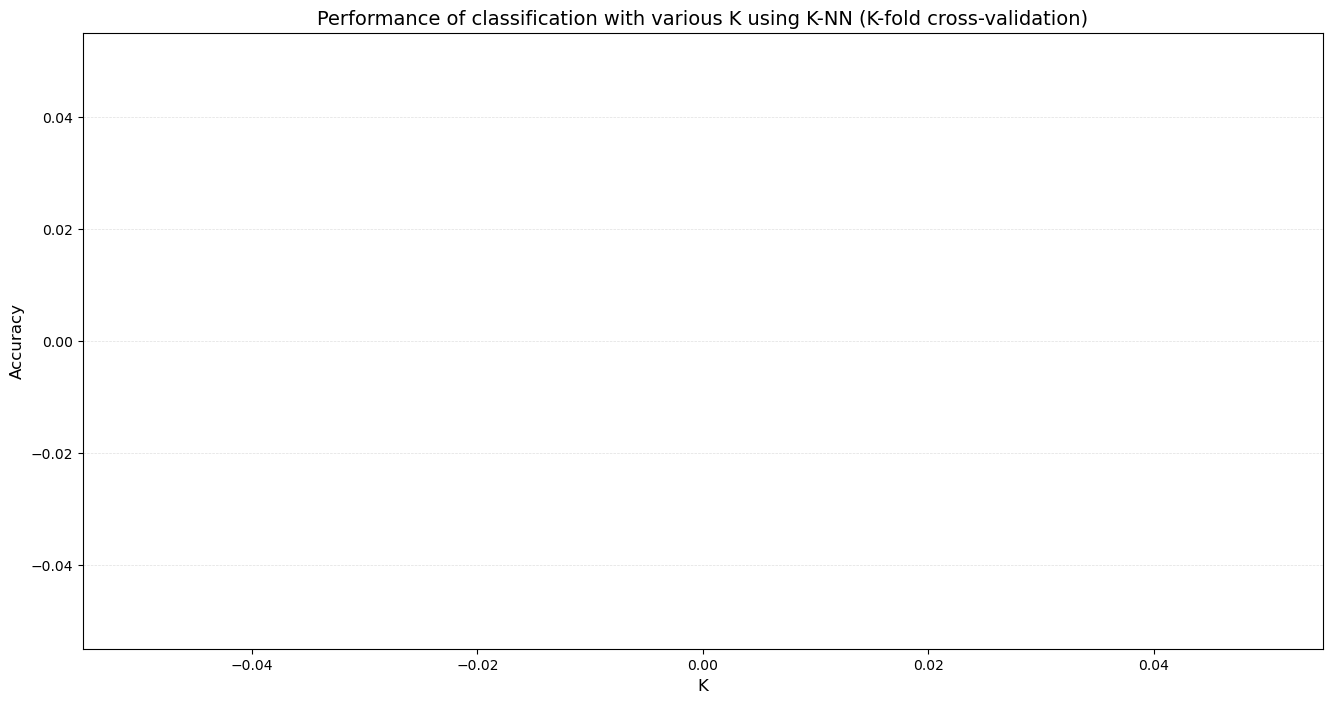

In [13]:
_, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.plot(results_nfold.keys(), results_nfold.values(), linestyle='None', marker='D')
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('K', fontsize=12)
ax.set_title(f'Performance of classification with various K using K-NN (K-fold cross-validation)', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.4, lw=0.5)


#### 2.4.2 Questions

(6 points)
___

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>Q </b></font> Pour quelle valeur(s) de k le modèle est-il le plus efficace ?</p>

Note: les résultats peuvent varier d'une exécution à l'autre. Indiquez la tendance générale.


*Réponse:*

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>Q </b></font> Une fois les données normalisées, quelle différence observe-t-on ?</p>

*Réponse:*

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>Q </b></font> Pourquoi normaliser/standardiser les données lorsqu'on utilise k-NN ?</p>

Décrivez rapidement les raisons et effets de la normalisation dans la logique de k-NN. 

*Réponse:*

<div class="alert alert-block alert-info">
<b>Corrections 2.4: </b> Points obtenus: /12
</div>

Remarques: 

## Exercice 3: Evaluation des résultats et matrice de confusion

(5 points)


Utilisez la bibliothèque scikit learn (sklearn.metrics, utilisé en première partie de ce TP au point 1.2.3) pour calculer la matrice de confusion du meilleur modèle trouvé précédemment avec les données normalisées (c.a.d., pour **un** K donné), sur l’ensemble de validation pour chaque « fold » de la validation croisée. **Y a-t-il des classes pour lesquelles nous avons plus de peine à faire la bonne classification ?** 



In [14]:
# Reprennez ici votre code de la partie précédente (mais cette fois avec un seul k) 
# Attention à changer les noms de variables si vous voulez réexécutez du code en amont du notebook. 

# - Votre code -


# Avec les valeurs rééles et prédites, afficher la matrice de confusion


# - Votre code - 



*Réponse:*



<div class="alert alert-block alert-info">
<b>Corrections 3: </b> Points obtenus: /5
</div>

Remarques: 

## Exercice 4: L’algorithme LVQ

Utilisez l’algorithme LVQ pour traiter le problème de classification des vins et testez la performance (accuracy) des modèles et calculez la matrice de confusion du meilleur modèle trouvé en explorant différentes valeurs d'hyper-paramètres (c.a.d., nombre de prototypes, learning rate et nombre d’epochs), sur l’ensemble de validation pour chaque « fold » de la validation croisée. 

**4.1) Exécutez le code donné**

Le code vous est donné en partie ci-dessous. Exécutez-le, remplissez la partie manquante (4.2), et répondez aux questions. 


In [15]:
from math import sqrt
from random import randrange
from random import seed
from random import shuffle

# calculate the Euclidean distance between two vectors
def euclidean_distance(row1: list, row2: list):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

# Locate the best matching unit
def get_best_matching_unit(codebook: list, test_row: list):
    distances = list()
    for codevector in codebook:
        dist = euclidean_distance(codevector, test_row)
        distances.append((codevector, dist))
    distances.sort(key=lambda tup: tup[1])
    return distances[0][0]

# Make a prediction with codebook vectors
def predict(codebooks: list, test_row: list):
	bmu = get_best_matching_unit(codebooks, test_row)
	return bmu[-1]

# LVQ Algorithm
def predict_lvq(train, test, n_codebooks, lrate, epochs):
    codebooks = train_codebook(train, n_codebooks, lrate, epochs)
    return [predict(codebooks, row) for row in test]

# Create a random codebook vector
def init_codevector(train,category):
    n_records = len(train)
    n_features = len(train[0])-1
    found = False
    while(not found):
        random_observation = randrange(n_records)
        if (train[random_observation][-1] == category):
            found = True
            
    codevector = [train[random_observation][i] for i in range(n_features)]
    codevector.append(category)
    return codevector

# Create a random codebook vector
def random_codebook(train):
	n_records = len(train)
	n_features = len(train[0])
	codebook = [train[randrange(n_records)][i] for i in range(n_features)]
	return codebook

# Train a set of codebook vectors
def train_codebook(train, n_codevectors, lrate, epochs):
    codebook = [random_codebook(train) for i in range(n_codevectors)]
    for epoch in range(epochs):
        rate = lrate * (1.0-(epoch/float(epochs)))
        sum_error = 0.0
        shuffle(train)
        for row in train:
            bmu = get_best_matching_unit(codebook, row)
            for i in range(len(row)-1):
                error = row[i] - bmu[i]
                sum_error += error**2
                if bmu[-1] == row[-1]:
                    bmu[i] += rate * error
                else:
                    bmu[i] -= rate * error
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, rate, sum_error))
    return codebook

Il n'y a pas besoin de modifier le code ci-dessous. 

In [16]:
# Le code ci-dessus attend la variable dépendante (Note) à la fin et non au début
# Quelques modifications s'imposent. 

# On garde le même scaler
scaler = StandardScaler()

# Créer une copie et prendre une liste des colonnes des données indépendantes (entrées)
df_normalized_end = wines.copy()
cols = wines.columns[wines.columns != 'Note']

# Remplacer les colonnes des données par les données transformées
df_normalized_end[cols] = scaler.fit_transform(df_normalized_end[cols])

# On prend la liste des colonnes et on met le premier élément à la fin
all_cols = df_normalized_end.columns.tolist()

all_cols = all_cols[1:] + [all_cols[0]]
print(f"Nouvel ordre des colonnes: {all_cols}")

df_normalized_end = df_normalized_end[all_cols]


# conversion en liste de listes pour k-NN
data_normalized_end = df_normalized_end.values.tolist()


Nouvel ordre des colonnes: ['Alcool', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline', 'Note']


In [17]:
# Parameters
seed(0)    # Pseudo aléatoire
lr = 0.3
n_epochs = 50
n_codevectors = 15

folds = cross_validation_split(data_normalized_end, n_folds=5)

predictions = []
actuals = []
results = defaultdict(list)
    
for test_i in range(len(folds)):
    
    train = list(itertools.chain.from_iterable(folds[:test_i] + folds[test_i+1:]))
    test = folds[test_i]
    
    predictions += predict_lvq(train, test, n_codevectors, lr, n_epochs)
    actuals += [i[-1] for i in test]
    print(actuals)
    print(predictions)
    print(f'Prediction of fold {test_i}: {accuracy_metric(actuals, predictions)}')


results[k] = accuracy_metric(actuals, predictions)
print(f'Performance of LVQ with ({lr=}, {n_epochs=}, {n_codevectors=}): {results[k]}')

>epoch=0, lrate=0.300, error=1939.794
>epoch=1, lrate=0.294, error=1671.179
>epoch=2, lrate=0.288, error=995.070
>epoch=3, lrate=0.282, error=1020.203
>epoch=4, lrate=0.276, error=978.699
>epoch=5, lrate=0.270, error=995.118
>epoch=6, lrate=0.264, error=1001.951
>epoch=7, lrate=0.258, error=1008.317
>epoch=8, lrate=0.252, error=985.716
>epoch=9, lrate=0.246, error=991.869
>epoch=10, lrate=0.240, error=944.570
>epoch=11, lrate=0.234, error=964.309
>epoch=12, lrate=0.228, error=950.920
>epoch=13, lrate=0.222, error=970.596
>epoch=14, lrate=0.216, error=952.848
>epoch=15, lrate=0.210, error=941.518
>epoch=16, lrate=0.204, error=945.091
>epoch=17, lrate=0.198, error=939.319
>epoch=18, lrate=0.192, error=947.325
>epoch=19, lrate=0.186, error=936.088
>epoch=20, lrate=0.180, error=939.759
>epoch=21, lrate=0.174, error=920.143
>epoch=22, lrate=0.168, error=907.719
>epoch=23, lrate=0.162, error=922.094
>epoch=24, lrate=0.156, error=908.364
>epoch=25, lrate=0.150, error=917.816
>epoch=26, lrate=

>epoch=12, lrate=0.228, error=1042.498
>epoch=13, lrate=0.222, error=1067.869
>epoch=14, lrate=0.216, error=1057.769
>epoch=15, lrate=0.210, error=1029.963
>epoch=16, lrate=0.204, error=1026.917
>epoch=17, lrate=0.198, error=1044.318
>epoch=18, lrate=0.192, error=1013.254
>epoch=19, lrate=0.186, error=1018.710
>epoch=20, lrate=0.180, error=999.798
>epoch=21, lrate=0.174, error=1013.830
>epoch=22, lrate=0.168, error=1033.747
>epoch=23, lrate=0.162, error=1003.098
>epoch=24, lrate=0.156, error=1015.317
>epoch=25, lrate=0.150, error=999.324
>epoch=26, lrate=0.144, error=1007.204
>epoch=27, lrate=0.138, error=1000.534
>epoch=28, lrate=0.132, error=990.299
>epoch=29, lrate=0.126, error=988.035
>epoch=30, lrate=0.120, error=981.240
>epoch=31, lrate=0.114, error=979.885
>epoch=32, lrate=0.108, error=965.576
>epoch=33, lrate=0.102, error=969.503
>epoch=34, lrate=0.096, error=969.001
>epoch=35, lrate=0.090, error=968.495
>epoch=36, lrate=0.084, error=963.957
>epoch=37, lrate=0.078, error=963.32

**4.2) Affichez la matrice de confusion**

(3 points)

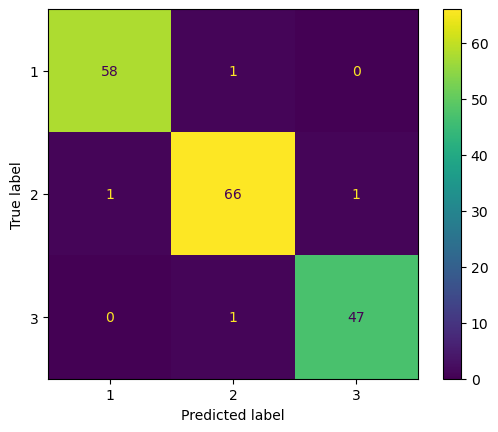

In [18]:
# Ecrivez le code pour la matrice de confusion (4 lignes suffisent)
# Calcul de la matrice de confusion
cm = confusion_matrix(actuals, predictions)

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3])
disp.plot()
plt.show()


____

**4.3) Questions**

(6 points)

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>Q </b></font>Commentez vos résultats et comparez l’accuracy de ce modèle avec celle obtenu avec k-NN.</p>

*Réponse:* Les résultats montrent que le modèle LVQ a obtenu une précision de 97.71%. **COMPAREZ AVEC LE K-NN EXO AVANT **

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>Q </b></font>Quelles sont les différences principales entre k-NN et LVQ au niveau algorithmique ?</p>

*Réponse:*Au niveau algorithmique, k-NN est un algorithme basé sur la proximité où la classification d'une observation est déterminée par la majorité des classes de ses K plus proches voisins. LVQ, d'autre part, est un type d'apprentissage supervisé basé sur les réseaux de neurones. Il utilise des prototypes (vecteurs de code) pour chaque classe et ajuste ces prototypes pendant l'entraînement pour mieux représenter les échantillons de chaque classe.

____
**4.4) Pseudo aléatoire**
(3 points)

**Exécutez le code ci-dessous plusieurs fois et observez les résultats. Dé-commentez la ligne qui fixe le générateur de nombre pseudo-aléatoires (*seed(0)*) et exécutez à nouveau la cellule plusieurs fois.**

>epoch=0, lrate=0.200, error=86.792
>epoch=1, lrate=0.187, error=51.040
>epoch=2, lrate=0.173, error=28.523
>epoch=3, lrate=0.160, error=25.216
>epoch=4, lrate=0.147, error=24.356
>epoch=5, lrate=0.133, error=24.166
>epoch=6, lrate=0.120, error=23.976
>epoch=7, lrate=0.107, error=23.563
>epoch=8, lrate=0.093, error=23.218
>epoch=9, lrate=0.080, error=22.961
>epoch=10, lrate=0.067, error=22.664
>epoch=11, lrate=0.053, error=22.420
>epoch=12, lrate=0.040, error=22.156
>epoch=13, lrate=0.027, error=21.878
>epoch=14, lrate=0.013, error=21.591
Codebook: [[2.404012188790385, 2.825975585543567, 0], [7.2375497581730714, 1.9850010133310267, 1]]


Text(0, 0.5, 'x2')

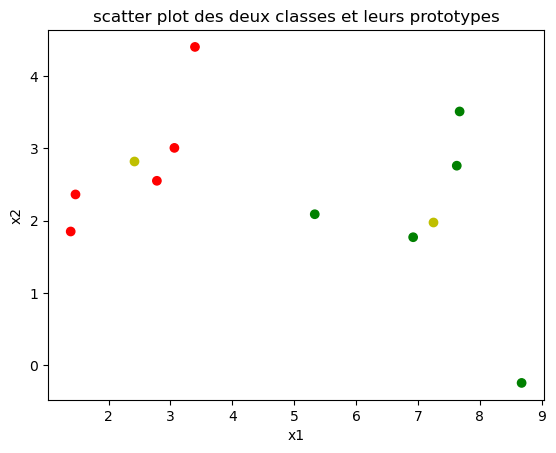

In [24]:
seed(0)
dataset = [[2.7810836,2.550537003,0],
[1.465489372,2.362125076,0],
[3.396561688,4.400293529,0],
[1.38807019,1.850220317,0],
[3.06407232,3.005305973,0],
[7.627531214,2.759262235,1],
[5.332441248,2.088626775,1],
[6.922596716,1.77106367,1],
[8.675418651,-0.242068655,1],
[7.673756466,3.508563011,1]]
learn_rate = 0.2
n_epochs = 15
n_codevectors = 2
codebook = train_codebook(dataset, n_codevectors, learn_rate, n_epochs)
print('Codebook: %s' % codebook)

colors = ['r','g','b']
plt.scatter([i[0] for i in codebook],[j[1] for j in codebook],c='y')
plt.scatter([i[0] for i in dataset],[j[1] for j in dataset],c=[colors[k[2]] for k in dataset])
plt.title("scatter plot des deux classes et leurs prototypes")
plt.xlabel("x1")
plt.ylabel("x2")

<p style="background-color:#AFEEEE;padding:3px"><font size="4"><b>Q </b></font>Que constatez-vous ? A quoi sert un générateur de nombre pseudo aléatoire ?</p>

*Réponse:* 

On constate que le résultat est toujours le même.



*À quoi sert un générateur de nombre pseudo aléatoire ?*

Un générateur de nombres pseudo-aléatoires est utilisé pour créer une séquence de nombres qui semble être aléatoire, mais qui est en fait déterminée par un point de départ initial, connu sous le nom de "graine" (seed) (Comme dans Minecraft).

L'utilisation de cette graine permet de reproduire exactement les mêmes résultats lors des exécutions successives du code qui va permettre de contrôler les expériences pour comparer différents modèles ou configurations. Fixer la graine garantit que les variations dans les résultats sont dues aux changements dans le modèle ou les paramètres, et non à la variabilité aléatoire.



<div class="alert alert-block alert-info">
<b>Corrections 4: </b> Points obtenus: /12
</div>

Remarques: 

FIN